In [1]:
from tensorflow.keras.utils import to_categorical
import numpy as np

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
import os

os.environ['PATH'] = '/media/susmit/disk/Xilinx/Vivado/2018.2/bin:' + os.environ['PATH']

2024-04-23 15:15:59.099436: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-23 15:15:59.134785: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-23 15:15:59.135184: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-23 15:15:59.879940: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from keras.models import load_model

model = load_model('my_model.h5')

2024-04-23 15:16:01.226676: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

In [4]:
import hls4ml
import plotting

# First, the baseline model
hls_config = hls4ml.utils.config_from_keras_model(model, granularity='name')

# Set the precision and reuse factor for the full model
hls_config['Model']['Precision'] = 'ap_fixed<16,6>'

for Layer in hls_config['LayerName'].keys():
    hls_config['LayerName'][Layer]['Precision'] = 'ap_fixed<16,6>'
    if Layer=='conv2d_1' or Layer=='dense':
        hls_config['LayerName'][Layer]['Strategy'] = 'resource'
        hls_config['LayerName'][Layer]['ReuseFactor'] = 16
    else:
        hls_config['LayerName'][Layer]['Strategy'] = 'latency'
        hls_config['LayerName'][Layer]['ReuseFactor'] = 1
    
# If you want best numerical performance for high-accuray models, while the default latency strategy is faster but numerically more unstable
hls_config['LayerName']['dense_softmax']['Strategy'] = 'Stable'
plotting.print_dict(hls_config)

cfg = hls4ml.converters.create_config(backend='Vivado')
cfg['IOType'] = 'io_stream'  # Must set this if using CNNs!
cfg['HLSConfig'] = hls_config
cfg['KerasModel'] = model
cfg['ProjectName'] = 'myproject1'
cfg['InputData'] = 'x_test.dat'
cfg['OutputPredictions:'] = 'y_test.dat'
cfg['OutputDir'] = 'my_model_proj1/'

hls_model = hls4ml.converters.keras_to_hls(cfg)

Interpreting Sequential
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 28, 28, 1]], output shape: [None, 28, 28, 1]
Layer name: conv2d, layer type: Conv2D, input shapes: [[None, 28, 28, 1]], output shape: [None, 26, 26, 32]
Layer name: max_pooling2d, layer type: MaxPooling2D, input shapes: [[None, 26, 26, 32]], output shape: [None, 13, 13, 32]
Layer name: conv2d_1, layer type: Conv2D, input shapes: [[None, 13, 13, 32]], output shape: [None, 11, 11, 64]
Layer name: max_pooling2d_1, layer type: MaxPooling2D, input shapes: [[None, 11, 11, 64]], output shape: [None, 5, 5, 64]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 5, 5, 64]], output shape: [None, 1600]
Layer name: dense, layer type: Dense, input shapes: [[None, 1600]], output shape: [None, 10]
Model
  Precision:         ap_fixed<16,6>
  ReuseFactor:       1
  Strategy:          Latency
  BramFactor:        1000000000
  TraceOutput:       False
LayerName
  input_1
    Trace:           F

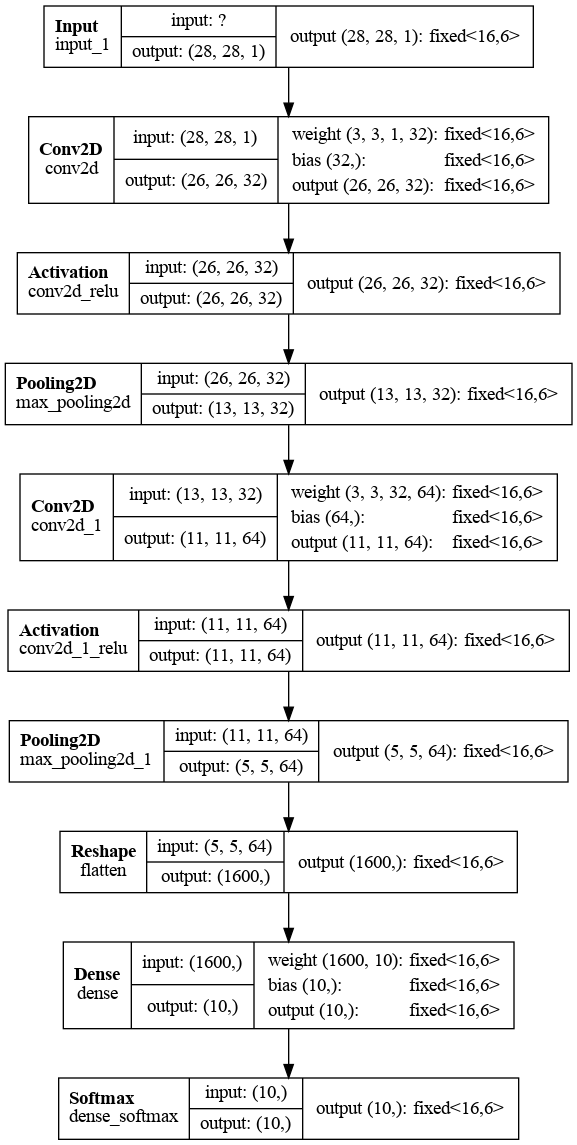

In [5]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

In [5]:
hls_model.compile()

Writing HLS project


/home/susmit/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done


In [6]:
import keras

(_, _), (x_test, y_test) = keras.datasets.mnist.load_data()
x_test = np.expand_dims(x_test.astype("float32") / 255, -1)
y_test = keras.utils.to_categorical(y_test, 10)

print(y_test[0:2])
hls_model.predict(x_test[0:2])

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [6]:
hls_model.build(csim=True, cosim=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2018.2 (64-bit)
  **** SW Build 2258646 on Thu Jun 14 20:02:38 MDT 2018
  **** IP Build 2256618 on Thu Jun 14 22:10:49 MDT 2018
    ** Copyright 1986-2018 Xilinx, Inc. All Rights Reserved.

source /media/susmit/disk/Xilinx/Vivado/2018.2/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/media/susmit/disk/Xilinx/Vivado/2018.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'susmit' on host 'susmit-Latitude-3400' (Linux_x86_64 version 5.4.0-177-generic) on Tue Apr 23 15:18:24 IST 2024
INFO: [HLS 200-10] On os Ubuntu 20.04.6 LTS
INFO: [HLS 200-10] In directory '/media/susmit/disk/Handwritten-digit-classification/my_model_proj1'
INFO: [HLS 200-10] Opening project '/media/susmit/disk/Handwritten-digit-classification/my_model_proj1/myproject1_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject1.cpp' to the project
INFO: [HLS 200-10] Adding test bench file 'myproject1_test.cpp' to th

INFO: [HLS 200-111] Finished Standard Transforms Time (s): cpu = 00:00:58 ; elapsed = 00:01:00 . Memory (MB): peak = 548.828 ; gain = 208.004 ; free physical = 8013 ; free virtual = 18832
INFO: [HLS 200-10] Checking synthesizability ...
INFO: [XFORM 203-602] Inlining function 'nnet::cast<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2_mult>' into 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2_mult>' (firmware/nnet_utils/nnet_dense_latency.h:66) automatically.
INFO: [XFORM 203-602] Inlining function 'nnet::Op_max<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0> >::operator()' into 'nnet::reduce<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 2, nnet::Op_max<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0> > >' (firmware/nnet_utils/nnet_common.h:43) automatically.
INFO: [XFORM 203-602] Inlining function 'nnet::reduce<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3,

INFO: [XFORM 203-501] Unrolling loop 'ReLUPackLoop' (firmware/nnet_utils/nnet_activation_stream.h:49) in function 'nnet::relu<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 32u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 32u>, relu_config3>' completely.
INFO: [XFORM 203-501] Unrolling loop 'Loop-1.1.1' (firmware/nnet_utils/nnet_pooling_stream.h:181) in function 'nnet::pooling2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 64u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 64u>, config7>' completely.
INFO: [XFORM 203-501] Unrolling loop 'UpdateBuffer' (firmware/nnet_utils/nnet_conv_stream.h:233) in function 'nnet::pooling2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 64u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 64u>, config7>' completely.
INFO: [XFORM 203-501] Unrolling loop 'LineBufferDataIn' (firmware/nnet_utils/nnet_conv_stream.h:241) in function 'nnet::pooling2d_cl<nnet::array<ap_

INFO: [XFORM 203-501] Unrolling loop 'UpdateBuffer' (firmware/nnet_utils/nnet_conv_stream.h:233) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 32u>, config5>' completely.
INFO: [XFORM 203-501] Unrolling loop 'LineBufferDataIn' (firmware/nnet_utils/nnet_conv_stream.h:241) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 32u>, config5>' completely.
INFO: [XFORM 203-501] Unrolling loop 'LineBufferShift' (firmware/nnet_utils/nnet_conv_stream.h:244) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 32u>, config5>' completely.
INFO: [XFORM 203-501] Unrolling loop 'KernelShiftWidth' (firmware/nnet_utils/nnet_conv_stream.h:194) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 32u>, config5>' completely.
INFO: [XFORM 203-501] Unrolling loop 'KernelShiftHeight' (firmware/nnet_utils/nnet_conv_stream.h:197)

INFO: [XFORM 203-101] Partitioning array 'tmp.data.V' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'line_buffer.Array.V.1' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'line_buffer.Array.V' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'b9.V'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'acc.V' (firmware/nnet_utils/nnet_dense_resource.h:33) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'kernel_data.V.1'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'res_out'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'b5.V'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'acc.V' (firmware/nnet_utils/nnet_dense_resource.h:33) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'shift_buffer.V' (firmware/nnet_utils/nnet_conv_stream.h:229) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'k

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2_mult>.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2_mult>.0.0' at call site (firmware/nnet_utils/nnet_conv_stream.h:294) by setting 'biases[0].V' to 'b2.V.0'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2_mult>.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2_mult>.0.0.0' at call site (firmware/nnet_utils/nnet_conv_stream.h:294) by setting 'biases[1].V' to 'b2.V.1'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2_mult>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2_mult>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_conv_stream.h:294) by setting 'biases[29].V' to 'b2.V.29'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2_mult>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2_mult>.0.0.0.0.0.0.0.0.0.0

INFO: [XFORM 203-541] Flattening a loop nest 'ReadInputHeight' (firmware/nnet_utils/nnet_conv2d_stream.h:79:66) in function 'nnet::conv_2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 32u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 64u>, config5>'.
INFO: [XFORM 203-541] Flattening a loop nest 'ReadInputHeight' (firmware/nnet_utils/nnet_conv2d_stream.h:79:66) in function 'nnet::conv_2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 32u>, config2>'.
INFO: [XFORM 203-531] Rewinding loop 'ReuseLoop' (firmware/nnet_utils/nnet_dense_resource.h:43) in function 'dense_wrapper<ap_fixed<16, 6, 5, 3, 0>, ap_fixed<16, 6, 5, 3, 0>, config9>'.
INFO: [XFORM 203-531] Rewinding loop 'ReuseLoop' (firmware/nnet_utils/nnet_dense_resource.h:43) in function 'dense_resource<ap_fixed<16, 6, 5, 3, 0>, ap_fixed<16, 6, 5, 3, 0>, config5_mult>'.
INFO: [HLS 200-111] Finished Architecture Synthesis T

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_1u_config2_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'shift_line_buffer<array<ap_fixed<16, 6, 5, 3, 0>, 1u>, config2>'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 1.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 1454.13 seconds; current allocated memory: 975.093 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.27 seconds; current allocated memory: 975.197 MB.
INFO: [HLS

INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 10.94 seconds; current allocated memory: 1.046 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'conv_2d_cl_array_ap_fixed_32u_array_ap_fixed_16_6_5_3_0_64u_config5_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 11.32 seconds; current allocated memory: 1.047 GB.
INFO: [HLS 200-434] Only 0 loops out of a total 1 loops have been pipelined in this design.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing var

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'myproject1' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 5.81 seconds; current allocated memory: 1.236 GB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 19.33 seconds; current allocated memory: 1.252 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_1u_config2_s' 
INFO: [HLS 200-10] ----------------------------------------

INFO: [SYN 201-210] Renamed object name 'pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_32u_config4_s_line_buffer_Array_V_2_0_0' to 'pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_32u_config4_s_line_buffer_Array_dEe' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_32u_config4_s_line_buffer_Array_V_2_0_1' to 'pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_32u_config4_s_line_buffer_Array_eOg' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_32u_config4_s_line_buffer_Array_V_2_0_2' to 'pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_32u_config4_s_line_buffer_Array_fYi' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_32u_config4_s_line_buffer_Array_V_2_0_3' to 'pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_32u_config4_s_line_buffer_Array_g8j' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 

INFO: [RTGEN 206-100] Generating core module 'myproject1_mux_42_16_1_1': 32 instance(s).
INFO: [RTGEN 206-100] Finished creating RTL model for 'pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_32u_config4_s'.
INFO: [HLS 200-111]  Elapsed time: 3.86 seconds; current allocated memory: 1.305 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_32u_config5_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_32u_config5_s_line_buffer_Array_V_1_0_0' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_32u_config5_s_line_buffer_Array_VJfO' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_32u_config5_s_line_buffer_Array_V_1_1_0' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_32u_config5_s_line_b

INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_32u_config5_s_line_buffer_Array_V_1_0_24' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_32u_config5_s_line_buffer_Array_Vbvn' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_32u_config5_s_line_buffer_Array_V_1_1_24' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_32u_config5_s_line_buffer_Array_Vbwn' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_32u_config5_s_line_buffer_Array_V_1_0_25' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_32u_config5_s_line_buffer_Array_Vbxn' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_32u_config5_s_line_buffer_Array_V_1_1_25' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_32u_config5_s_line_buffer_Array_Vbyn' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 

INFO: [RTGEN 206-104] Estimated max fanout for 'compute_output_buffer_2d_array_array_ap_fixed_16_6_5_3_0_64u_config5_s' is 7816 from HDL expression: ((ap_start == 1'b1) & (1'b1 == ap_CS_fsm_state1))
INFO: [RTGEN 206-100] Finished creating RTL model for 'compute_output_buffer_2d_array_array_ap_fixed_16_6_5_3_0_64u_config5_s'.
INFO: [HLS 200-111]  Elapsed time: 94.8 seconds; current allocated memory: 1.803 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_array_ap_fixed_32u_array_ap_fixed_16_6_5_3_0_64u_config5_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_array_ap_fixed_32u_array_ap_fixed_16_6_5_3_0_64u_config5_s'.
INFO: [HLS 200-111]  Elapsed time: 13.17 seconds; current allocated memory: 1.820 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
IN

INFO: [SYN 201-210] Renamed object name 'pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_64u_config7_s_line_buffer_Array_V_3_0_0' to 'pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_64u_config7_s_line_buffer_Array_bLp' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_64u_config7_s_line_buffer_Array_V_3_0_1' to 'pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_64u_config7_s_line_buffer_Array_bMq' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_64u_config7_s_line_buffer_Array_V_3_0_2' to 'pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_64u_config7_s_line_buffer_Array_bNq' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_64u_config7_s_line_buffer_Array_V_3_0_3' to 'pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_64u_config7_s_line_buffer_Array_bOq' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 

INFO: [SYN 201-210] Renamed object name 'pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_64u_config7_s_line_buffer_Array_V_3_0_37' to 'pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_64u_config7_s_line_buffer_Array_cmv' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_64u_config7_s_line_buffer_Array_V_3_0_38' to 'pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_64u_config7_s_line_buffer_Array_cnw' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_64u_config7_s_line_buffer_Array_V_3_0_39' to 'pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_64u_config7_s_line_buffer_Array_cow' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_64u_config7_s_line_buffer_Array_V_3_0_40' to 'pooling2d_cl_array_array_ap_fixed_16_6_5_3_0_64u_config7_s_line_buffer_Array_cpw' due to the length limit 80
INFO: [SYN 201-210] Renamed object n

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_array_ap_fixed_64u_array_ap_fixed_16_6_5_3_0_10u_config9_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_array_ap_fixed_64u_array_ap_fixed_16_6_5_3_0_10u_config9_s'.
INFO: [HLS 200-111]  Elapsed time: 152.65 seconds; current allocated memory: 2.224 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'reduce_ap_fixed_18_8_0_0_0_4_Op_add_ap_fixed_18_8_0_0_0_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Generating core module 'myproject1_mux_104_18_1_1': 4 instance(s).
INFO: [RTGEN 206-100] Finished creating RTL model for 'reduce_ap_fixed_18_8_0_0_0_4_Op_add_ap_fixed_18_8_0_0_0_s'.
INFO: [HLS 200-111]  Elaps

INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_8_V_U(fifo_w16_d676_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_9_V_U(fifo_w16_d676_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_10_V_U(fifo_w16_d676_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_11_V_U(fifo_w16_d676_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_12_V_U(fifo_w16_d676_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_13_V_U(fifo_w16_d676_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_14_V_U(fifo_w16_d676_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_15_V_U(fifo_w16_d676_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_16_V_U(fifo_w16_d676_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_17_V_U(fifo_w16_d676_A)' using Bloc

INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_V_data_30_V_U(fifo_w16_d121_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_V_data_31_V_U(fifo_w16_d121_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_V_data_32_V_U(fifo_w16_d121_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_V_data_33_V_U(fifo_w16_d121_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_V_data_34_V_U(fifo_w16_d121_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_V_data_35_V_U(fifo_w16_d121_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_V_data_36_V_U(fifo_w16_d121_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_V_data_37_V_U(fifo_w16_d121_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_V_data_38_V_U(fifo_w16_d121_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_V_data_39_V_U(fifo_w16_d121_A)' using Bl

INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_V_data_51_V_U(fifo_w16_d121_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_V_data_52_V_U(fifo_w16_d121_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_V_data_53_V_U(fifo_w16_d121_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_V_data_54_V_U(fifo_w16_d121_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_V_data_55_V_U(fifo_w16_d121_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_V_data_56_V_U(fifo_w16_d121_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_V_data_57_V_U(fifo_w16_d121_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_V_data_58_V_U(fifo_w16_d121_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_V_data_59_V_U(fifo_w16_d121_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_V_data_60_V_U(fifo_w16_d121_A)' using Bl

INFO: [RTMG 210-285] Implementing FIFO 'start_for_softmax_array_array_ap_fixed_16_6_5_3_0_10u_softmax_config10_U0_U(start_for_softmax_array_array_ap_fixed_16_6_5_3_0_10u_softmax_config10_U0)' using Shift Registers.
INFO: [HLS 200-111] Finished generating all RTL models Time (s): cpu = 00:54:43 ; elapsed = 00:55:55 . Memory (MB): peak = 2885.035 ; gain = 2544.211 ; free physical = 4281 ; free virtual = 16463
INFO: [SYSC 207-301] Generating SystemC RTL for myproject1.
INFO: [VHDL 208-304] Generating VHDL RTL for myproject1.
INFO: [VLOG 209-307] Generating Verilog RTL for myproject1.
***** C/RTL SYNTHESIS COMPLETED IN 0h55m47s *****
***** C/RTL SIMULATION *****
INFO: [HLS 200-10] Adding test bench file 'myproject1_test.cpp' to the project
INFO: [COSIM 212-47] Using XSIM for RTL simulation.
INFO: [COSIM 212-14] Instrumenting C test bench ...
   Build using "/media/susmit/disk/Xilinx/Vivado/2018.2/tps/lnx64/gcc-6.2.0/bin/g++"
   Compiling myproject1_test.cpp_pre.cpp.tb.cpp
   Compiling apat

INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/media/susmit/disk/Handwritten-digit-classification/my_model_proj1/myproject1_prj/solution1/sim/verilog/conv_2d_cl_array_ap_fixed_1u_array_ap_fixed_16_6_5_3_0_32u_config2_s.v" into library xil_defaultlib
INFO: [VRFC 10-311] analyzing module conv_2d_cl_array_ap_fixed_1u_array_ap_fixed_16_6_5_3_0_32u_config2_s
INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/media/susmit/disk/Handwritten-digit-classification/my_model_proj1/myproject1_prj/solution1/sim/verilog/conv_2d_cl_array_ap_fixed_32u_array_ap_fixed_16_6_5_3_0_64u_config5_s.v" into library xil_defaultlib
INFO: [VRFC 10-311] analyzing module conv_2d_cl_array_ap_fixed_32u_array_ap_fixed_16_6_5_3_0_64u_config5_s
INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/media/susmit/disk/Handwritten-digit-classification/my_model_proj1/myproject1_prj/solution1/sim/verilog/dense_array_ap_fixed_64u_array_ap_fixed_16_6_5_3_0_10u_config9_s.v" into library xil_defaultlib
INFO: [VRFC 10-311] analy

Starting static elaboration
Completed static elaboration
Starting simulation data flow analysis
Completed simulation data flow analysis
Time Resolution for simulation is 1ps
Compiling module xil_defaultlib.dense_latency_0_0_0_0_0_0_0_0_0_...
Compiling module xil_defaultlib.shift_line_buffer_array_ap_fixed...
Compiling module xil_defaultlib.shift_line_buffer_array_ap_fixed...
Compiling module xil_defaultlib.shift_line_buffer_array_ap_fixed...
Compiling module xil_defaultlib.compute_output_buffer_2d_array_a...
Compiling module xil_defaultlib.conv_2d_cl_array_ap_fixed_1u_arr...
Compiling module xil_defaultlib.relu_array_ap_fixed_32u_array_ap...
Compiling module xil_defaultlib.pooling2d_cl_array_array_ap_fixe...
Compiling module xil_defaultlib.pooling2d_cl_array_array_ap_fixe...
Compiling module xil_defaultlib.myproject1_mux_42_16_1_1(ID=1,di...
Compiling module xil_defaultlib.pooling2d_cl_array_array_ap_fixe...
Compiling module xil_defaultlib.dense_resource_ap_fixed_16_6_5_3...
Compiling 

// RTL Simulation : 1 / 1 [100.00%] @ "13188000"
////////////////////////////////////////////////////////////////////////////////////
$finish called at time : 13207500 ps : File "/media/susmit/disk/Handwritten-digit-classification/my_model_proj1/myproject1_prj/solution1/sim/verilog/myproject1.autotb.v" Line 711
## quit
INFO: [Common 17-206] Exiting xsim at Tue Apr 23 16:18:15 2024...
INFO: [COSIM 212-316] Starting C post checking ...
INFO: Unable to open input/predictions file, using default input.
0.114258 0.166992 0.0839844 0.0839844 0.0839844 0.0839844 0.0888672 0.107422 0.0947266 0.0947266 
INFO: Saved inference results to file: tb_data/rtl_cosim_results.log
INFO:
Report time       : Tue 23 Apr 2024 04:17:06 PM IST.
Solution          : solution1.
Simulation tool   : xsim.

+----------+----------+-----------------------------------------------+-----------------------------------------------+
|          |          |                    Latency                    |                    I

{'CSimResults': [['0.114258',
   '0.166992',
   '0.0839844',
   '0.0839844',
   '0.0839844',
   '0.0839844',
   '0.0888672',
   '0.107422',
   '0.0947266',
   '0.0947266']],
 'CosimResults': [['0.114258',
   '0.166992',
   '0.0839844',
   '0.0839844',
   '0.0839844',
   '0.0839844',
   '0.0888672',
   '0.107422',
   '0.0947266',
   '0.0947266']],
 'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '4.215',
  'BestLatency': '3561',
  'WorstLatency': '3562',
  'IntervalMin': '789',
  'IntervalMax': '3551',
  'BRAM_18K': '1185',
  'DSP': '2393',
  'FF': '195339',
  'LUT': '194180',
  'URAM': '0',
  'AvailableBRAM_18K': '5376',
  'AvailableDSP': '12288',
  'AvailableFF': '3456000',
  'AvailableLUT': '1728000',
  'AvailableURAM': '1280'},
 'VivadoSynthReport': {'LUT': '147977',
  'FF': '145305',
  'BRAM_18K': '113.5',
  'URAM': '0',
  'DSP48E': '2392'},
 'CosimReport': {'RTL': 'Verilog',
  'Status': 'Pass',
  'LatencyMin': 2613,
  'LatencyMax': 2613,
  'IntervalMin'

In [8]:
# Print out the report
hls4ml.report.read_vivado_report('my_model_proj1',full_report=True)

Found 1 solution(s) in my_model_proj1/myproject1_prj.
Reports for solution "solution1":

C SIMULATION RESULT:
INFO: [SIM 2] *************** CSIM start ***************
INFO: [SIM 4] CSIM will launch GCC as the compiler.
   Compiling ../../../../myproject1_test.cpp in debug mode
   Compiling ../../../../firmware/myproject1.cpp in debug mode
   Generating csim.exe
INFO: Unable to open input/predictions file, using default input.
0.114258 0.166992 0.0839844 0.0839844 0.0839844 0.0839844 0.0888672 0.107422 0.0947266 0.0947266 
INFO: Saved inference results to file: tb_data/csim_results.log
INFO: [SIM 1] CSim done with 0 errors.
INFO: [SIM 3] *************** CSIM finish ***************

SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject1'
* Date:           Tue Apr 23 16:13:40 2024

* Version:        2018.2 (Build 2258646 on Thu Jun 14 20:25:20 MDT 2018)
* Project:        myproject1_prj
* Solution:       solution1
* Product family: virtexuplus
* Target device:  xcvu13p-flga2577-2-e


== Pe